# Notebook d'interprétation des erreurs de pédiction | Stanford dogs dataset
## Adrian Rodriguez
## Projet 6 parcours Ingénieur Machine Learning
Accès projet git : https://github.com/Adrian1903/Classez-des-images-l-aide-d-algorithmes-de-Deep-Learning  
Plus d'informations : https://openclassrooms.com/fr/paths/148-ingenieur-machine-learning

---
# 0. Contexte

Vous êtes bénévole pour l'association de protection des animaux de votre quartier. C'est d'ailleurs ainsi que vous avez trouvé votre compagnon idéal, Snooky. Vous vous demandez donc ce que vous pouvez faire en retour pour aider l'association.

Vous apprenez, en discutant avec un bénévole, que leur base de données de pensionnaires commence à s'agrandir et qu'ils n'ont pas toujours le temps de référencer les images des animaux qu'ils ont accumulées depuis plusieurs années. Ils aimeraient donc obtenir un algorithme capable de classer les images en fonction de la race du chien présent sur l'image.

## Les données
Les bénévoles de l'association n'ont pas eu le temps de réunir les différentes images des pensionnaires dispersées sur leurs disques durs. Pas de problème, vous entraînerez votre algorithme en utilisant le Stanford Dogs Dataset.

## Votre mission
L'association vous demande de réaliser un algorithme de détection de la race du chien sur une photo, afin d'accélérer leur travail d’indexation.

Vous avez peu d’expérience sur le sujet, vous décidez donc de contacter un ami expert en classification d’images.

Il vous conseille dans un premier temps de pré-processer des images avec des techniques spécifiques (e.g. whitening, equalization, éventuellement modification de la taille des images) et de réaliser de la data augmentation (mirroring, cropping...).

Ensuite, il vous incite à mettre en œuvre deux approches s’appuyant sur l’état de l’art et l’utilisation de CNN (réseaux de neurones convolutionnels), que vous comparerez en termes de temps de traitement et de résultat :

* Une première en réalisant votre propre réseau CNN, en vous inspirant de réseaux CNN existants. Prenez soin d'optimiser certains hyperparamètres (des layers du modèle, de la compilation du modèle et de l’exécution du modèle)
* Une deuxième en utilisant le transfer learning, c’est-à-dire en utilisant un réseau déjà entraîné, et en le modifiant pour répondre à votre problème.
Concernant le transfer learning, votre ami vous précise que :

* Une première chose obligatoire est de réentraîner les dernières couches pour prédire les classes qui vous intéressent seulement.
* Il est également possible d’adapter la structure (supprimer certaines couches, par exemple) ou de réentraîner le modèle avec un très faible learning rate pour ajuster les poids à votre problème (plus long) et optimiser les performances.

## Ressources de calcul
Votre ami vous alerte sur le fait que l'entraînement (même partiel) d'un réseau de neurones convolutionnels est très gourmand en ressources. Si le processeur de l’ordinateur un peu ancien de l’association ne suffit pas, il vous propose plusieurs solutions :

* Limitez le jeu de données, en ne sélectionnant que quelques classes (races de chiens), ce qui permettra déjà de tester la démarche et la conception des modèles, avant une éventuelle généralisation.
* Utilisez la carte graphique de l’ordinateur en tant que GPU (l'installation est un peu fastidieuse, et l'ordinateur est inutilisable le temps du calcul).

Ce notebook aide à l'interprétation des erreurs ayant lieu en production

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("default")
import seaborn as sns

from keras.models import load_model
from keras.preprocessing.image import load_img, img_to_array

In [87]:
def get_breed(file):
    image = load_img(file, target_size=(299, 299))
    input_array = np.reshape(img_to_array(image), (-1, 299, 299, 3)) / 255

    # Prédiction de la race
    output = model.predict(input_array)
    return class_label.at[output.argmax(axis=-1)[0], 'index']

def get_top3_breeds(model, file):
    image = load_img(file, target_size=(299, 299))
    input_array = np.reshape(img_to_array(image), (-1, 299, 299, 3)) / 255

    # Prédiction de la race
    output = model.predict(input_array)

    df_out = pd.DataFrame(output[0])
    top3_breeds = pd.merge(class_label, df_out, left_index=True, right_index=True).rename(columns={0: 'Probabilité', 'index': 'Race prédite'}).sort_values('Probabilité', ascending=False).head(3)
    return top3_breeds


def get_true_breed(file):
    return file.split('\\')[-2].split('-')[1]

# 1. Chargement du modèle

In [48]:
model = load_model('api/src/best_model_Xception_DataAugmentation_120_breeds.hdf5')
class_label = pd.read_csv('api/src/class_labels.csv')
test_file = pd.read_csv('src/dog_test_split.csv')

# 2. Extraction des prédictions en erreur

In [69]:
print(f'Nous avons {test_file.shape[0]} images de test')

Nous avons 4116 données de test


In [68]:
%time test_file["predicted_breeds"] = test_file.uri.apply(lambda x: get_breed(x))
test_file

Wall time: 20min 18s


uri  ...             predicted_breeds
0      src\img\n02096585-Boston_bull\n02096585_1571.jpg  ...                  Boston_bull
1       src\img\n02113624-toy_poodle\n02113624_2224.jpg  ...             miniature_poodle
2     src\img\n02093256-Staffordshire_bullterrier\n0...  ...    Staffordshire_bullterrier
3            src\img\n02115641-dingo\n02115641_2513.jpg  ...                        dingo
4     src\img\n02098286-West_Highland_white_terrier\...  ...  West_Highland_white_terrier
...                                                 ...  ...                          ...
4111  src\img\n02093256-Staffordshire_bullterrier\n0...  ...    Staffordshire_bullterrier
4112  src\img\n02105641-Old_English_sheepdog\n021056...  ...         Old_English_sheepdog
4113  src\img\n02093991-Irish_terrier\n02093991_727.jpg  ...                Irish_terrier
4114  src\img\n02093647-Bedlington_terrier\n02093647...  ...           Bedlington_terrier
4115       src\img\n02101556-clumber\n02101556_4712.jpg  ...                      clumber

[4116 rows x 3 columns]

In [105]:
 error_predict.uri[2]

'src\\img\\n02095889-Sealyham_terrier\\n02095889_1582.jpg'

In [104]:
error_predict = test_file[test_file.breeds != test_file.predicted_breeds]
error_predict.reset_index(drop=True, inplace=True)
error_predict

uri  ...             predicted_breeds
0      src\img\n02113624-toy_poodle\n02113624_2224.jpg  ...             miniature_poodle
1    src\img\n02097209-standard_schnauzer\n02097209...  ...          miniature_schnauzer
2    src\img\n02095889-Sealyham_terrier\n02095889_1...  ...  soft-coated_wheaten_terrier
3    src\img\n02085782-Japanese_spaniel\n02085782_4...  ...                     Pekinese
4    src\img\n02094433-Yorkshire_terrier\n02094433_...  ...                silky_terrier
..                                                 ...  ...                          ...
512          src\img\n02096177-cairn\n02096177_223.jpg  ...               Border_terrier
513        src\img\n02098413-Lhasa\n02098413_11467.jpg  ...                     Shih-Tzu
514  src\img\n02102040-English_springer\n02102040_6...  ...  German_short-haired_pointer
515  src\img\n02096294-Australian_terrier\n02096294...  ...                silky_terrier
516  src\img\n02098286-West_Highland_white_terrier\...  ...                  Maltese_dog

[517 rows x 3 columns]

In [76]:
accuracy_best_model = round((test_file.shape[0] - error_predict.shape[0]) / test_file.shape[0]*100, 1)
print(f'Précision du modèle : {accuracy_best_model} %)

Précision du modèle : 87.4 %


# 3. Etude des cas en erreur

Cas n°1


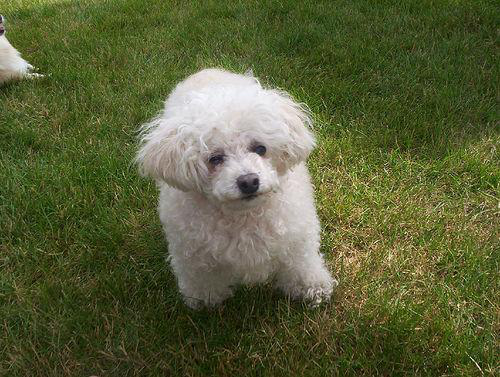

'Race indiquée par les données : toy_poodle'

Race prédite  Probabilité
104  miniature_poodle     0.652671
115        toy_poodle     0.347219
41   Lakeland_terrier     0.000037

#############################################################

Cas n°2


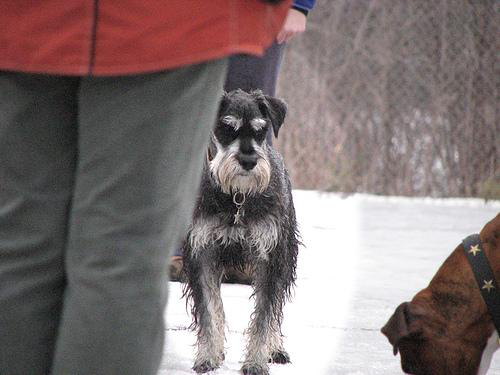

'Race indiquée par les données : standard_schnauzer'

Race prédite   Probabilité
105  miniature_schnauzer  8.540148e-01
114   standard_schnauzer  1.459850e-01
94       giant_schnauzer  1.734081e-07

#############################################################

Cas n°3


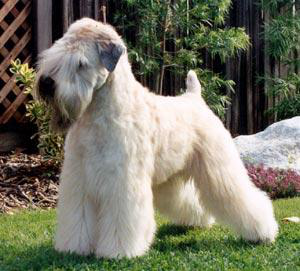

'Race indiquée par les données : Sealyham_terrier'

Race prédite  Probabilité
112  soft-coated_wheaten_terrier     0.956069
61              Sealyham_terrier     0.037118
41              Lakeland_terrier     0.003409

#############################################################

Cas n°4


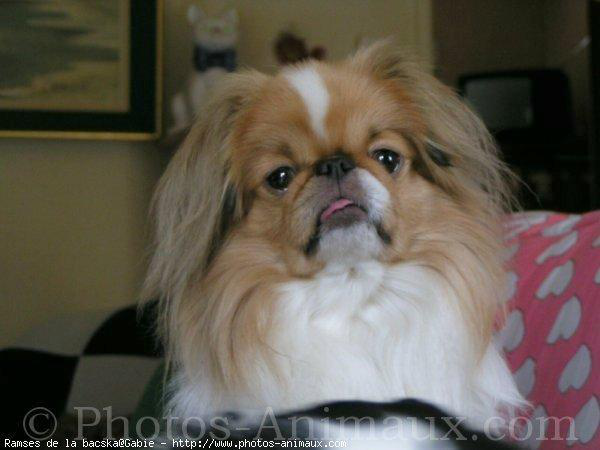

'Race indiquée par les données : Japanese_spaniel'

Race prédite  Probabilité
51          Pekinese     0.682957
38  Japanese_spaniel     0.316960
63          Shih-Tzu     0.000057

#############################################################

Cas n°5


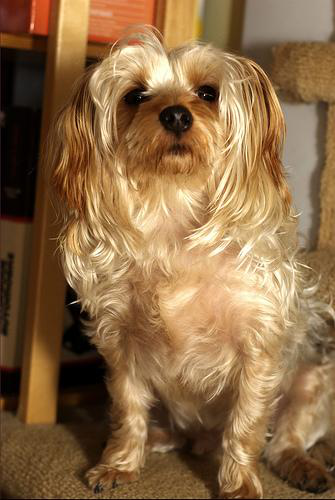

'Race indiquée par les données : Yorkshire_terrier'

Race prédite  Probabilité
111       silky_terrier     0.556029
73    Yorkshire_terrier     0.438189
5    Australian_terrier     0.005672

#############################################################

Cas n°6


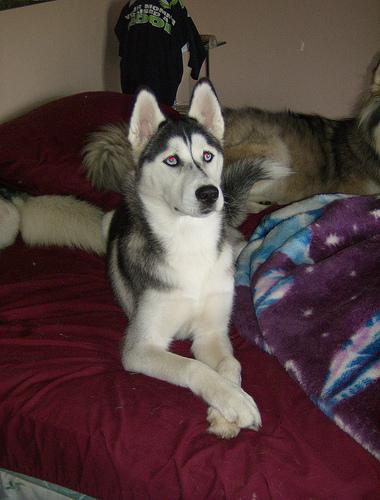

'Race indiquée par les données : Eskimo_dog'

Race prédite  Probabilité
64   Siberian_husky     0.703306
24       Eskimo_dog     0.241923
101        malamute     0.054724

#############################################################

Cas n°7


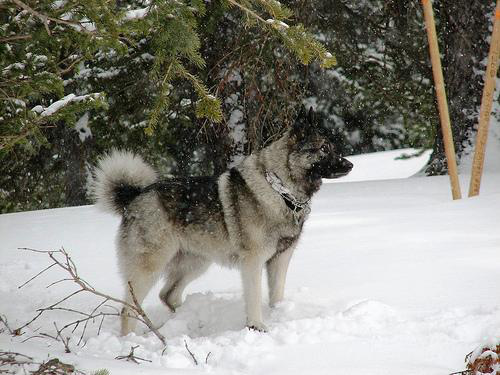

'Race indiquée par les données : Norwegian_elkhound'

Race prédite  Probabilité
101            malamute     0.633134
48   Norwegian_elkhound     0.357203
24           Eskimo_dog     0.006938

#############################################################

Cas n°8


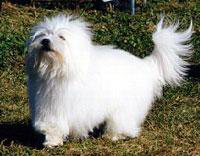

'Race indiquée par les données : Dandie_Dinmont'

Race prédite  Probabilité
68  Tibetan_terrier     0.726645
44      Maltese_dog     0.108285
43            Lhasa     0.054459

#############################################################

Cas n°9


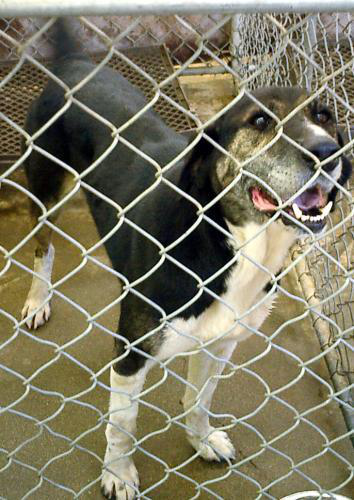

'Race indiquée par les données : Walker_hound'

Race prédite  Probabilité
40     Labrador_retriever     0.055117
29             Great_Dane     0.046484
93  flat-coated_retriever     0.044625

#############################################################

Cas n°10


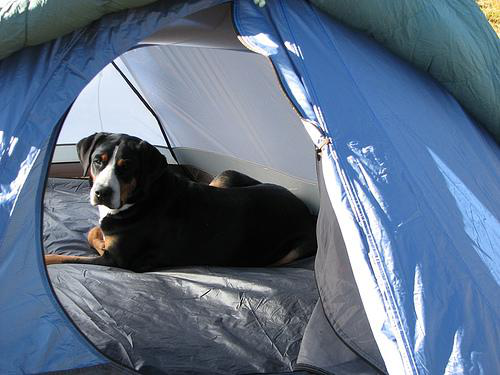

'Race indiquée par les données : Greater_Swiss_Mountain_dog'

Race prédite  Probabilité
23                 EntleBucher     0.616894
31  Greater_Swiss_Mountain_dog     0.232896
4                  Appenzeller     0.139398

#############################################################



In [91]:
i = 1
for img in error_predict.uri.head(100):
    print(f"Cas n°{i}")
    display(load_img(img))
    display("Race indiquée par les données : " + get_true_breed(img))
    display(get_top3_breeds(model, img))
    print("#############################################################")
    print("")
    i += 1

## 3-1. Retour sur le cas n°3

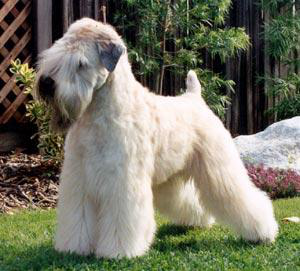

'Race indiquée par les données : Sealyham_terrier'

Race prédite  Probabilité
112  soft-coated_wheaten_terrier     0.956069
61              Sealyham_terrier     0.037118
41              Lakeland_terrier     0.003409

In [96]:
img = error_predict.uri[2]
display(load_img(img))
display("Race indiquée par les données : " + get_true_breed(img))
display(get_top3_breeds(model, img))

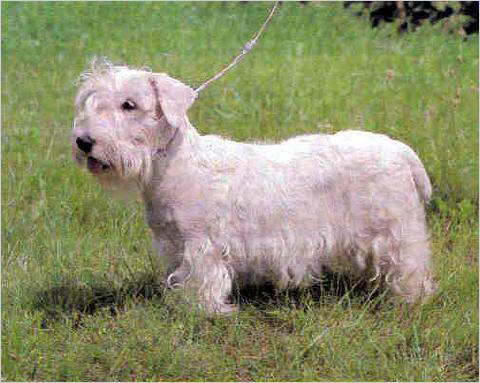

In [97]:
file = 'src/img/n02095889-Sealyham_terrier/n02095889_61.jpg'
display(load_img(file))

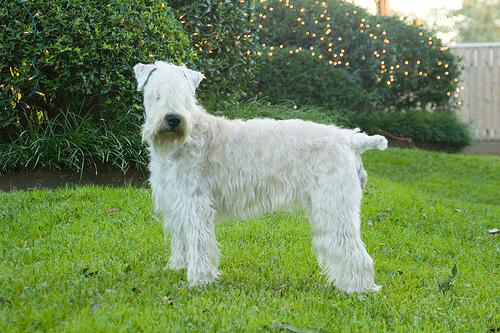

In [106]:
file = 'src/img/n02098105-soft-coated_wheaten_terrier/n02098105_3591.jpg'
display(load_img(file))

Dans ce cas, il s'agit d'une erreur humaine. La photo est dans le mauvais dossier (mauvaise race attribué). Cependant, l'ordinateur a identifié la bonne race.

---

La race attendue est arrivée en 2nde position. A première vue, on pourrait croit que la machine s'est trompée. Dans ce cas, on ne peut pas totalement attribuer l'erreur à la machine, car elle a reconnu une couleur rousse et noire avec des poils longs, qui sont présent dans les deux photos, et qui correspond à la race prédite.

Testons avec la même photo recadrée...

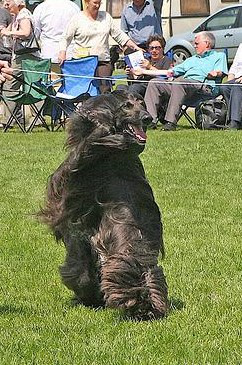

Race prédite  Probabilité
0     Afghan_hound     0.953777
83          briard     0.019904
66  Sussex_spaniel     0.017398

In [38]:
file='src/n02088094_93_ recadrée.jpg'
display(load_img(file))
display(get_top3_breeds(model, file))

Une fois la photo recadrée, la machine ne se trompe plus. Pour résoudre ce problème, nous pouvons former l'humain à mieux qualifier les photos à donner à la machine.

## 2-2. Cas n°2

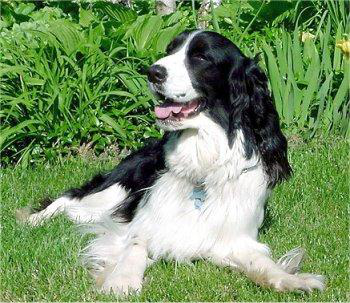

'Race indiquée par les données : Japanese_spaniel'

Race prédite  Probabilité
9      Border_collie     0.818158
22  English_springer     0.086938
89            collie     0.024353

In [41]:
file='src/img/n02085782-Japanese_spaniel/n02085782_381.jpg'
display(load_img(file))
display("Race indiquée par les données : " + get_true_breed(file))
display(get_top3_breeds(model, file))

Ici, le résultat diffère encore de la race indiquée par l'association.

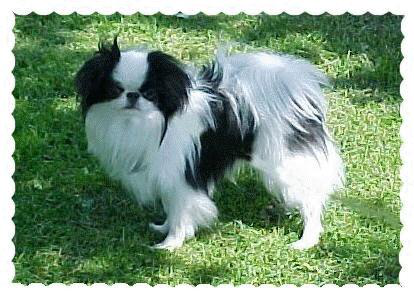

In [8]:
# Japenese spaniel
file='../input/stanford-dogs-dataset/images/Images/n02085782-Japanese_spaniel/n02085782_2.jpg'
display(load_img(file))

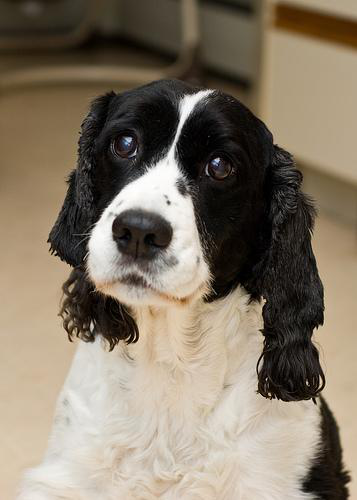

In [9]:
# English springer
file='../input/stanford-dogs-dataset/images/Images/n02102040-English_springer/n02102040_835.jpg'
display(load_img(file))

En regardant de plus près, on peut constater que l'association s'est trompée de race, et que la machine ne s'est pas trompée en prédisant la vraie race. On peut même constater la photo est présente de le bon dossier.

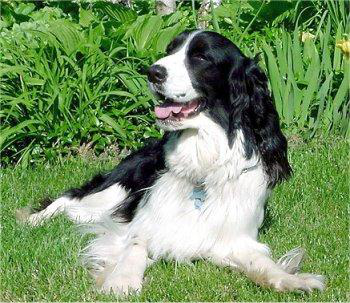

In [10]:
# Photo également présente dans le dossier english springer
file='../input/stanford-dogs-dataset/images/Images/n02102040-English_springer/n02102040_639.jpg'
image = load_img(file)
image

Le cas est reproduit une nouvelle fois. la photo n02086910_103 de la race papillon est également présente dans la race japenese_spaniel, et que la machine ne se trompe toujours pas malgré l'erreur humaine.

'Dossier papillon'

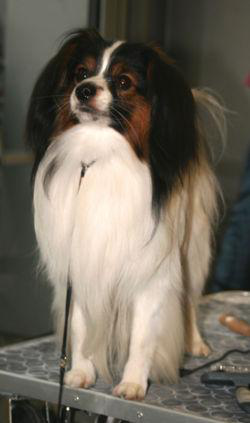

'Dossier Japenese spaniel'

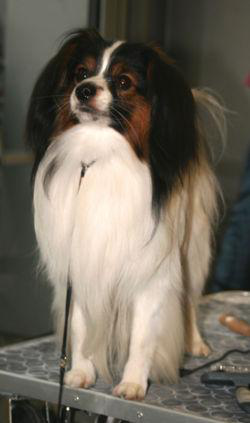

In [11]:
file='../input/stanford-dogs-dataset/images/Images/n02086910-papillon/n02086910_103.jpg'
display("Dossier papillon")
display(load_img(file))

display("Dossier Japenese spaniel")
file='../input/stanford-dogs-dataset/images/Images/n02085782-Japanese_spaniel/n02085782_50.jpg'
display(load_img(file))

# 3. Conclusion
En corrigeant ses erreurs courantes, nous pouvons encore améliorer considérablement les performances de l'algorithmes. Je recommande d'être soigneux dans le choix des photos à donner en apprentissage pour la machine.